# Step 1. Generating Transactions from Mobility Dataset

In [1]:
# import all necessary packages
import pandas as pd
import hypernetx as hnx
import pandas as pd
from mlxtend.preprocessing import TransactionEncoder
from mlxtend.frequent_patterns import fpgrowth, fpmax
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import matplotlib.pyplot as plt
from collections import defaultdict
from matplotlib.ticker import MaxNLocator
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

/Users/user/miniconda3/lib/python3.9/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


In [2]:
dataset_path = 'YJMob100k/yjmob100k-dataset1.csv' #path to the mobility dataframe
# The original dataset has 200x200 grid (area of a grid cell = 1/2 km x1/2 km = 0.25 km^2)
# Scaling_factor 10 (200/10 x 200/10) aggregates it to a 20x20 grid (area of a grid cell = 5 km x 5 km = 25 km^2)
scaling_factor = 10
min_support = 0.02 #change minimum support threshold for itemsets to be considered frequent 0.01 (1%), 0.02 (2%)
details = 'emergency_week_ms0.02_ds1'
#(0, 59) for business-as-usual, and (60, 74) for emergency
start_day = 60
end_day = 74

In [3]:
def generate_set_of_transactions_by_day(dataset_path, scaling_factor, start_day, end_day):
    mob_df = pd.read_csv(dataset_path)
    print("Head of input mobility dataset")
    print(mob_df.head())
    mob_df['grouped_x'] = (mob_df['x'] - 1) // scaling_factor + 1
    mob_df['grouped_y'] = (mob_df['y'] - 1) // scaling_factor + 1
    mob_df['week'] = (mob_df['d'] // 7) + 1  # Week number starting from 1
    mob_df = mob_df.loc[(mob_df['d'] >= start_day) & (mob_df['d'] <= end_day)]
    print("Head after agggregation")
    print(mob_df.head())  
    # Initialize a dictionary to store unique transactions for each user. A transaction is a set of 
    # locations visited by user in any single day (\Delta T = 1 day)
    user_transactions = {}
    count = 0
    # Group mob_df by user and then by day to collect unique sets of locations visited per user in any day
    for uid, group in mob_df.groupby('uid'):
        count += 1
        if count % 10000 == 0:
            print(count)
        # Set to store unique transactions for this user
        unique_transactions = set()
    
        # Loop over each day for this user and collect the unique set of locations
        for day, day_group in group.groupby('week'):
            # Get the unique set of locations visited on this day
            transaction = frozenset(zip(day_group['grouped_x'], day_group['grouped_y']))
            # Only keep the transaction if it hasn't been seen for this user
            if transaction not in unique_transactions:
                unique_transactions.add(transaction)

        # Store the unique transactions for this user
        user_transactions[uid] = unique_transactions

    # Flatten the transactions to a single list of sets
    transactions = [transaction for transactions in user_transactions.values() for transaction in transactions]
    return transactions

In [4]:
transactions = generate_set_of_transactions_by_day(dataset_path, scaling_factor, start_day, end_day)

Head of input mobility dataset
   uid  d   t   x   y
0    0  0   1  79  86
1    0  0   2  79  86
2    0  0   8  77  86
3    0  0   9  77  86
4    0  0  19  81  89
Head after agggregation
     uid   d   t    x   y  grouped_x  grouped_y  week
942    0  60  12   84  88          9          9     9
943    0  60  13   96  70         10          7     9
944    0  60  14  115  78         12          8     9
945    0  60  15  114  78         12          8     9
946    0  60  19  114  78         12          8     9
10000
20000
30000
40000
50000
60000
70000
80000
90000
100000


In [5]:
print(len(transactions))

288923


# Step 2. Computing Frequent Itemsets from Transactions Using FPGrowth

In [6]:
# Computes and returns all frequent itemsets given min_support and threshold. min_support is the 
# minimum fraction of total transactions in which the itemset appears; Set min_support to a suitable 
# threshold (for instance, 0.05 is 5%, 0.01 is 1%, 0.005 is 0.5%, 0.001 is 0.1%). min_itemset_size is the
# minimum number of items in any itemset. By setting it to 2, we get frequent itemsets which are of size 
# at least 2 (two or more locations are visited in the itemset).
def get_frequent_itemsets(transactions, min_sup, min_itemset_size):
    te = TransactionEncoder()
    te_ary = te.fit(transactions).transform(transactions)
    df = pd.DataFrame(te_ary, columns=te.columns_)  
    frequent_itemsets = fpgrowth(df, min_support=min_sup, use_colnames=True)
    print("Total frequent itemsets: ", len(frequent_itemsets))
    frequent_itemsets_filtered = frequent_itemsets[
        frequent_itemsets['itemsets'].apply(lambda x: len(x) >= min_itemset_size)
    ]
    print("Filtered frequent itemsets: ", len(frequent_itemsets_filtered))
    return frequent_itemsets_filtered

In [7]:
frequent_itemsets_order_ge1 = get_frequent_itemsets(transactions, min_support, 1)
frequent_itemsets_order_ge1.sort_values(by=['support'], ascending=False)

Total frequent itemsets:  815
Filtered frequent itemsets:  815


,support,itemsets
13,0.267099,"((14, 8))"
23,0.253088,"((14, 9))"
0,0.207962,"((13, 9))"
319,0.166480,"((14, 8), (14, 9))"
1,0.158869,"((13, 8))"
...,...,...
361,0.020040,"((14, 10), (14, 11), (15, 9))"
493,0.020030,"((16, 7), (14, 8), (15, 7), (15, 8))"
535,0.020016,"((16, 7), (17, 6), (18, 6))"
240,0.020012,"((13, 8), (11, 11), (12, 9))"


In [8]:
frequent_itemsets_order_ge2 = get_frequent_itemsets(transactions, min_support, 2)
frequent_itemsets_order_ge2.sort_values(by=['support'], ascending=False)

Total frequent itemsets:  815
Filtered frequent itemsets:  659


,support,itemsets
319,0.166480,"((14, 8), (14, 9))"
156,0.131547,"((13, 9), (14, 9))"
157,0.126805,"((13, 9), (14, 8))"
160,0.103595,"((13, 8), (14, 8))"
166,0.095326,"((13, 9), (12, 9))"
...,...,...
361,0.020040,"((14, 10), (14, 11), (15, 9))"
493,0.020030,"((16, 7), (14, 8), (15, 7), (15, 8))"
535,0.020016,"((16, 7), (17, 6), (18, 6))"
240,0.020012,"((13, 8), (11, 11), (12, 9))"


In [9]:
frequent_itemsets_order_ge3 = get_frequent_itemsets(transactions, min_support, 3)
frequent_itemsets_order_ge3.sort_values(by=['support'], ascending=False)

Total frequent itemsets:  815
Filtered frequent itemsets:  265


,support,itemsets
158,0.090079,"((13, 9), (14, 9), (14, 8))"
163,0.066779,"((13, 8), (14, 8), (14, 9))"
162,0.065114,"((13, 8), (13, 9), (14, 8))"
164,0.059490,"((13, 8), (13, 9), (14, 9))"
412,0.056333,"((14, 8), (14, 9), (15, 8))"
...,...,...
699,0.020068,"((15, 10), (15, 11), (14, 10))"
361,0.020040,"((14, 10), (14, 11), (15, 9))"
493,0.020030,"((16, 7), (14, 8), (15, 7), (15, 8))"
535,0.020016,"((16, 7), (17, 6), (18, 6))"


In [10]:
frequent_itemsets_order_ge4 = get_frequent_itemsets(transactions, min_support, 4)
frequent_itemsets_order_ge4.sort_values(by=['support'], ascending=False)

Total frequent itemsets:  815
Filtered frequent itemsets:  33


,support,itemsets
165,0.046608,"((13, 8), (13, 9), (14, 9), (14, 8))"
180,0.037591,"((13, 9), (14, 9), (14, 8), (12, 9))"
173,0.031095,"((13, 8), (13, 9), (14, 8), (12, 9))"
436,0.030032,"((13, 9), (14, 9), (14, 8), (15, 9))"
432,0.029613,"((14, 8), (14, 9), (15, 8), (15, 9))"
256,0.029610,"((13, 9), (13, 10), (14, 9), (14, 8))"
415,0.029281,"((13, 9), (14, 9), (15, 8), (14, 8))"
352,0.028824,"((13, 9), (14, 9), (14, 10), (14, 8))"
174,0.027821,"((13, 8), (13, 9), (14, 9), (12, 9))"
360,0.026633,"((14, 8), (14, 9), (14, 10), (14, 11))"


In [11]:
frequent_itemsets_order_ge5 = get_frequent_itemsets(transactions, min_support, 5)
frequent_itemsets_order_ge5.sort_values(by=['support'], ascending=False)

Total frequent itemsets:  815
Filtered frequent itemsets:  1


,support,itemsets
176,0.021573,"((13, 8), (14, 8), (12, 9), (13, 9), (14, 9))"


In [ ]:
frequent_itemsets_order_ge6 = get_frequent_itemsets(transactions, min_support, 6)
frequent_itemsets_order_ge6.sort_values(by=['support'], ascending=False)

In [ ]:
frequent_itemsets_order_ge7 = get_frequent_itemsets(transactions, min_support, 7)
frequent_itemsets_order_ge7.sort_values(by=['support'], ascending=False)

# Step 3. Constructing Hypergraphs from Frequent Itemsets

In [12]:
def construct_hypergraph_from_frequent_itemsets(frequent_itemsets):
    hyperedges = frequent_itemsets['itemsets'].tolist()
    H = hnx.Hypergraph({f"{i}": list(edge) for i, edge in enumerate(hyperedges)})
    print("(#nodes, #edges): ", H.shape)
    components = H.s_connected_components(edges = True, return_singletons=True)
    comp_id = 0
    for comp in components:
        comp_id += 1
        print("size of component "+str(comp_id)+": "+str(len(comp)))
    return H, hyperedges

In [13]:
# Hypergraph with all hyperedges of order 2 or greater
H_order_ge1, hyperedges_order_ge1 = construct_hypergraph_from_frequent_itemsets(frequent_itemsets_order_ge1)

/Users/user/miniconda3/lib/python3.9/site-packages/hypernetx/classes/entityset.py:150: DeprecationWarning: misc_props_col and misc_cell_props_col will be deprecated; all public references to these arguments will be removed in a future release.
  warnings.warn(
/Users/user/miniconda3/lib/python3.9/site-packages/hypernetx/classes/hypergraph.py:563: FutureWarning: This method or function will be deprecated in a future release. Public references to this method or function will be removed from the Hypergraph API in a future release.
  self._nodes = self.E.restrict_to_levels([1])
/Users/user/miniconda3/lib/python3.9/site-packages/hypernetx/classes/entityset.py:618: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  elements = self._dataframe.groupby(col1)[col2].unique().to_dict()
/Users/user/miniconda3/lib/p

(#nodes, #edges):  (156, 815)
size of component 1: 745
size of component 2: 3
size of component 3: 13
size of component 4: 1
size of component 5: 1
size of component 6: 1
size of component 7: 1
size of component 8: 1
size of component 9: 1
size of component 10: 1
size of component 11: 1
size of component 12: 1
size of component 13: 1
size of component 14: 1
size of component 15: 1
size of component 16: 1
size of component 17: 1
size of component 18: 1
size of component 19: 1
size of component 20: 1
size of component 21: 1
size of component 22: 1
size of component 23: 1
size of component 24: 1
size of component 25: 1
size of component 26: 1
size of component 27: 1
size of component 28: 1
size of component 29: 1
size of component 30: 1
size of component 31: 1
size of component 32: 1
size of component 33: 1
size of component 34: 1
size of component 35: 1
size of component 36: 1
size of component 37: 1
size of component 38: 1
size of component 39: 1
size of component 40: 1
size of componen

In [14]:
# Hypergraph with all hyperedges of order 2 or greater
H_order_ge2, hyperedges_order_ge2 = construct_hypergraph_from_frequent_itemsets(frequent_itemsets_order_ge2)

(#nodes, #edges):  (102, 659)


/Users/user/miniconda3/lib/python3.9/site-packages/hypernetx/classes/entityset.py:150: DeprecationWarning: misc_props_col and misc_cell_props_col will be deprecated; all public references to these arguments will be removed in a future release.
  warnings.warn(
/Users/user/miniconda3/lib/python3.9/site-packages/hypernetx/classes/hypergraph.py:563: FutureWarning: This method or function will be deprecated in a future release. Public references to this method or function will be removed from the Hypergraph API in a future release.
  self._nodes = self.E.restrict_to_levels([1])
/Users/user/miniconda3/lib/python3.9/site-packages/hypernetx/classes/entityset.py:618: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  elements = self._dataframe.groupby(col1)[col2].unique().to_dict()
/Users/user/miniconda3/lib/p

size of component 1: 651
size of component 2: 7
size of component 3: 1


In [15]:
xy_grid_loop = []

# Nested loops to iterate over x and y values
for x in range(1, 21):
    for y in range(1, 21):
        xy_grid_loop.append((x, y))
        
total_nodes = len(xy_grid_loop)
print(total_nodes)

400


In [16]:
H_order_ge3, hyperedges_order_ge3 = construct_hypergraph_from_frequent_itemsets(frequent_itemsets_order_ge3)

(#nodes, #edges):  (44, 265)
size of component 1: 264
size of component 2: 1


/Users/user/miniconda3/lib/python3.9/site-packages/hypernetx/classes/entityset.py:150: DeprecationWarning: misc_props_col and misc_cell_props_col will be deprecated; all public references to these arguments will be removed in a future release.
  warnings.warn(
/Users/user/miniconda3/lib/python3.9/site-packages/hypernetx/classes/hypergraph.py:563: FutureWarning: This method or function will be deprecated in a future release. Public references to this method or function will be removed from the Hypergraph API in a future release.
  self._nodes = self.E.restrict_to_levels([1])
/Users/user/miniconda3/lib/python3.9/site-packages/hypernetx/classes/entityset.py:618: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  elements = self._dataframe.groupby(col1)[col2].unique().to_dict()
/Users/user/miniconda3/lib/p

In [17]:
H_order_ge4, hyperedges_order_ge4 = construct_hypergraph_from_frequent_itemsets(frequent_itemsets_order_ge4)

(#nodes, #edges):  (16, 33)
size of component 1: 33


/Users/user/miniconda3/lib/python3.9/site-packages/hypernetx/classes/entityset.py:150: DeprecationWarning: misc_props_col and misc_cell_props_col will be deprecated; all public references to these arguments will be removed in a future release.
  warnings.warn(
/Users/user/miniconda3/lib/python3.9/site-packages/hypernetx/classes/hypergraph.py:563: FutureWarning: This method or function will be deprecated in a future release. Public references to this method or function will be removed from the Hypergraph API in a future release.
  self._nodes = self.E.restrict_to_levels([1])
/Users/user/miniconda3/lib/python3.9/site-packages/hypernetx/classes/entityset.py:618: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  elements = self._dataframe.groupby(col1)[col2].unique().to_dict()
/Users/user/miniconda3/lib/p

In [18]:
H_order_ge5, hyperedges_order_ge5 = construct_hypergraph_from_frequent_itemsets(frequent_itemsets_order_ge5)

(#nodes, #edges):  (5, 1)
size of component 1: 1


/Users/user/miniconda3/lib/python3.9/site-packages/hypernetx/classes/entityset.py:150: DeprecationWarning: misc_props_col and misc_cell_props_col will be deprecated; all public references to these arguments will be removed in a future release.
  warnings.warn(
/Users/user/miniconda3/lib/python3.9/site-packages/hypernetx/classes/hypergraph.py:563: FutureWarning: This method or function will be deprecated in a future release. Public references to this method or function will be removed from the Hypergraph API in a future release.
  self._nodes = self.E.restrict_to_levels([1])
/Users/user/miniconda3/lib/python3.9/site-packages/hypernetx/classes/entityset.py:618: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  elements = self._dataframe.groupby(col1)[col2].unique().to_dict()
/Users/user/miniconda3/lib/p

In [ ]:
H_order_ge6, hyperedges_order_ge6 = construct_hypergraph_from_frequent_itemsets(frequent_itemsets_order_ge6)

# Step 4. Plot various properties of hypergraph nodes and edges

In [19]:
def plot_hypergraph_on_xy_grid(H, plot_path):
    plt.figure(figsize=(12, 12))
    ax = plt.subplot(111)
    # Define the grid range
    grid_size = 20
    grid_color = 'lightgray'

    # Add manual grid lines
    for i in range(grid_size + 1):
        # Vertical lines
        ax.add_line(Line2D([i, i], [0, grid_size], color=grid_color, linestyle='-', linewidth=1, zorder=0))
        # Horizontal lines
        ax.add_line(Line2D([0, grid_size], [i, i], color=grid_color, linestyle='-', linewidth=1, zorder=0))

    node_labels_kwargs = {
        'fontsize': 6,         # Font size of the node labels
        'color': 'k',        # Color of the node labels
        'verticalalignment': 'top',  # Vertical alignment of the label
        'horizontalalignment': 'left' # Horizontal alignment of the label
    }

    # Use node labels directly as (x, y) coordinates
    # Assuming H_order3 nodes are something like (0,0), (5,10), (10,5), etc.
    pos = {node: node for node in H.nodes}  # Node labels are used as positions
    plt.grid(True)
    hnx.draw(H, ax=ax, pos = pos, with_edge_labels = False, with_node_labels = True, node_radius=0.01,
         node_labels_kwargs=node_labels_kwargs)
    plt.tight_layout()
    plt.savefig(plot_path, dpi = 600)
    plt.show()

/Users/user/miniconda3/lib/python3.9/site-packages/hypernetx/classes/entityset.py:150: DeprecationWarning: misc_props_col and misc_cell_props_col will be deprecated; all public references to these arguments will be removed in a future release.
  warnings.warn(
/Users/user/miniconda3/lib/python3.9/site-packages/hypernetx/classes/entityset.py:1494: RuntimeWarning: The values in the array are unorderable. Pass `sort=False` to suppress this warning.
  properties = props.combine_first(self.properties)
/Users/user/miniconda3/lib/python3.9/site-packages/hypernetx/classes/hypergraph.py:563: FutureWarning: This method or function will be deprecated in a future release. Public references to this method or function will be removed from the Hypergraph API in a future release.
  self._nodes = self.E.restrict_to_levels([1])
/Users/user/miniconda3/lib/python3.9/site-packages/hypernetx/classes/entityset.py:618: FutureWarning: The default of observed=False is deprecated and will be changed to True in a

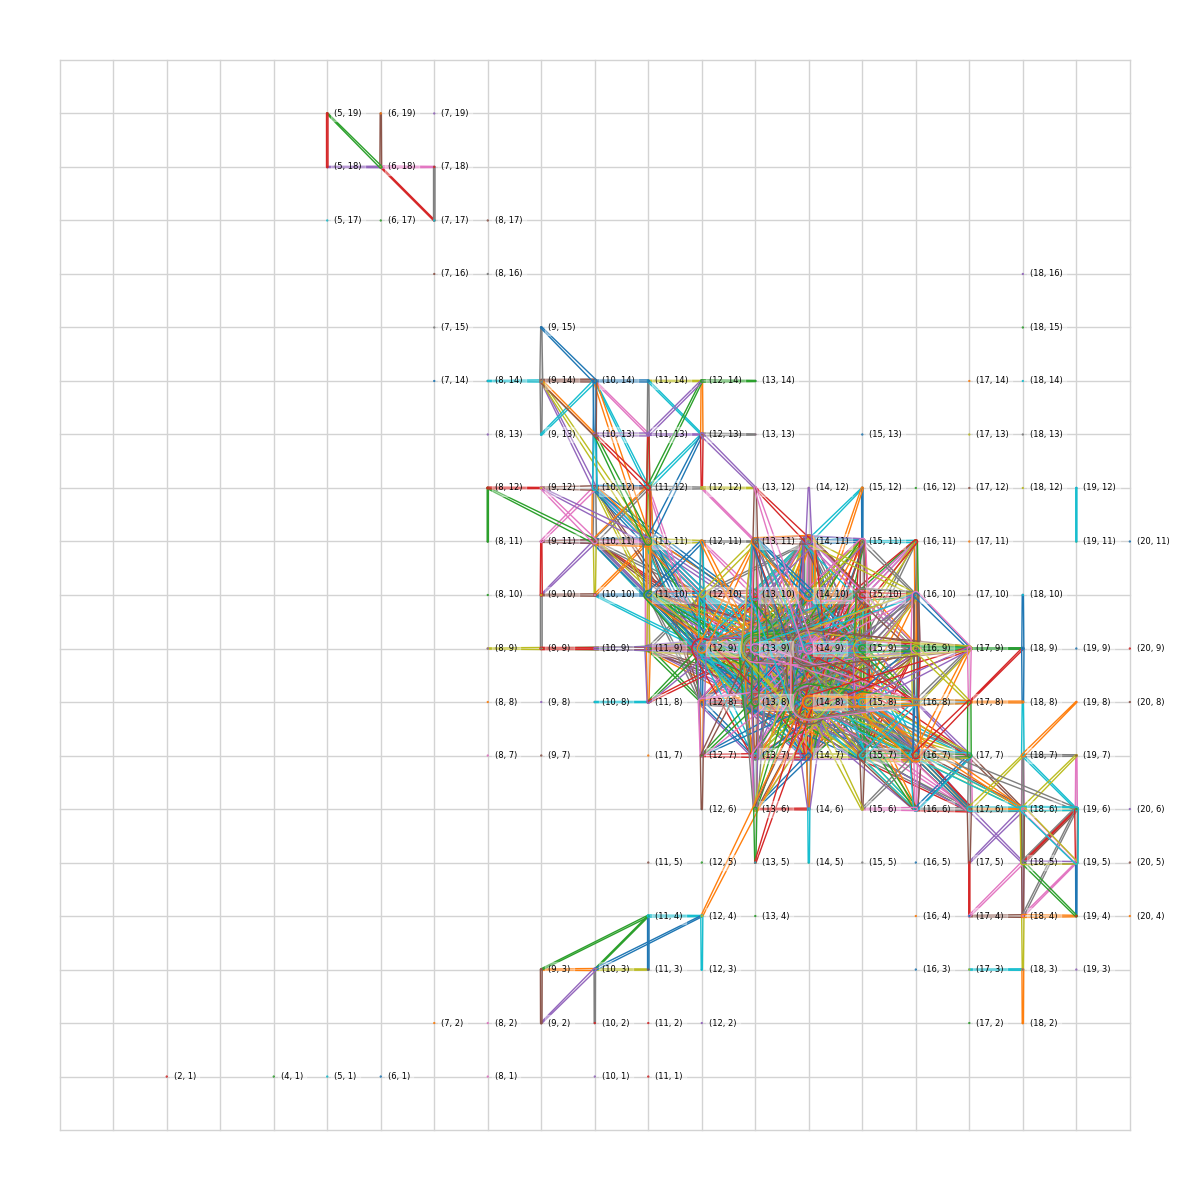

In [20]:
plot_path = 'figures/hg_order_ge1_'+str(details)+'.png'
plot_hypergraph_on_xy_grid(H_order_ge1, plot_path)

/Users/user/miniconda3/lib/python3.9/site-packages/hypernetx/classes/entityset.py:150: DeprecationWarning: misc_props_col and misc_cell_props_col will be deprecated; all public references to these arguments will be removed in a future release.
  warnings.warn(
/Users/user/miniconda3/lib/python3.9/site-packages/hypernetx/classes/entityset.py:1494: RuntimeWarning: The values in the array are unorderable. Pass `sort=False` to suppress this warning.
  properties = props.combine_first(self.properties)
/Users/user/miniconda3/lib/python3.9/site-packages/hypernetx/classes/hypergraph.py:563: FutureWarning: This method or function will be deprecated in a future release. Public references to this method or function will be removed from the Hypergraph API in a future release.
  self._nodes = self.E.restrict_to_levels([1])
/Users/user/miniconda3/lib/python3.9/site-packages/hypernetx/classes/entityset.py:618: FutureWarning: The default of observed=False is deprecated and will be changed to True in a

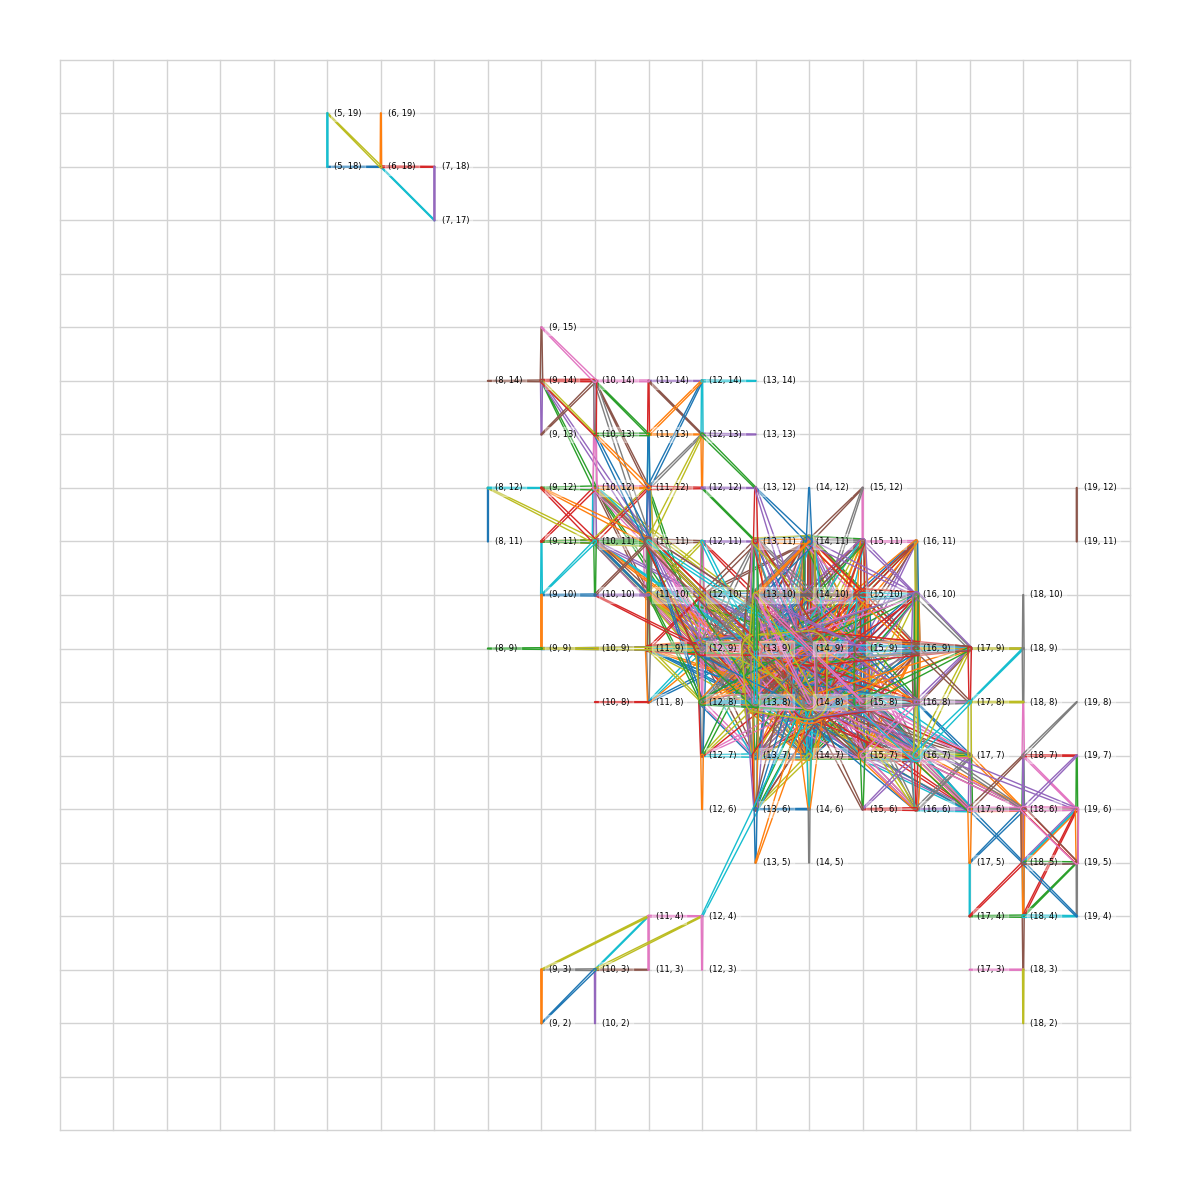

In [21]:
plot_path = 'figures/hg_order_ge2_'+str(details)+'.png'
plot_hypergraph_on_xy_grid(H_order_ge2, plot_path)

/Users/user/miniconda3/lib/python3.9/site-packages/hypernetx/classes/entityset.py:150: DeprecationWarning: misc_props_col and misc_cell_props_col will be deprecated; all public references to these arguments will be removed in a future release.
  warnings.warn(
/Users/user/miniconda3/lib/python3.9/site-packages/hypernetx/classes/entityset.py:1494: RuntimeWarning: The values in the array are unorderable. Pass `sort=False` to suppress this warning.
  properties = props.combine_first(self.properties)
/Users/user/miniconda3/lib/python3.9/site-packages/hypernetx/classes/hypergraph.py:563: FutureWarning: This method or function will be deprecated in a future release. Public references to this method or function will be removed from the Hypergraph API in a future release.
  self._nodes = self.E.restrict_to_levels([1])
/Users/user/miniconda3/lib/python3.9/site-packages/hypernetx/classes/entityset.py:618: FutureWarning: The default of observed=False is deprecated and will be changed to True in a

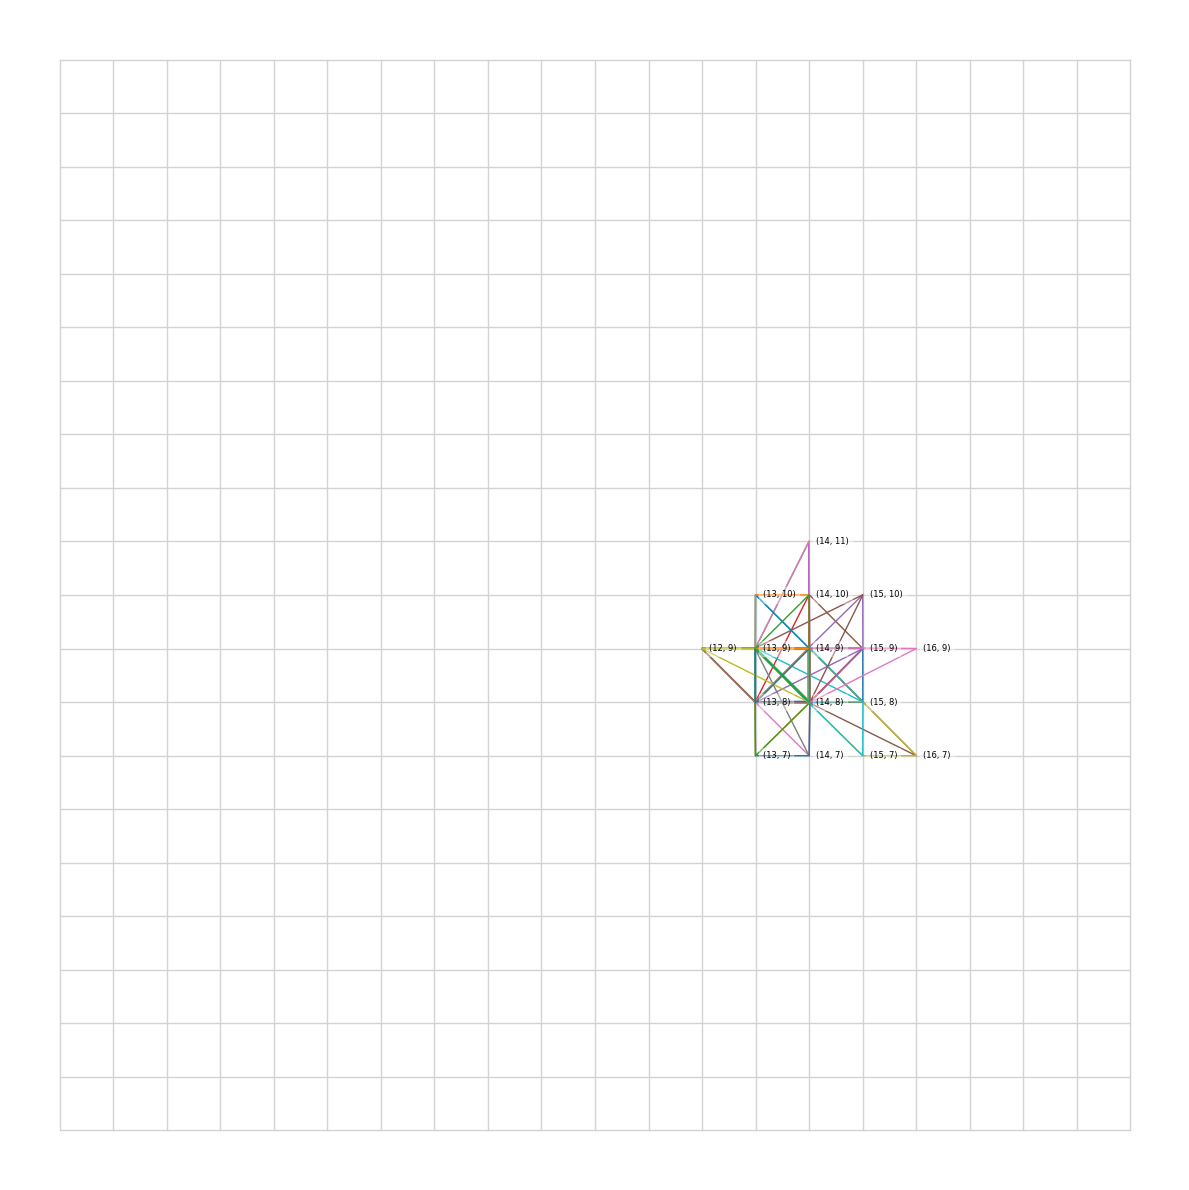

In [22]:
plot_path = 'figures/hg_order_ge4_'+str(details)+'.png'
plot_hypergraph_on_xy_grid(H_order_ge4, plot_path)

In [23]:
def plot_degree_distribution(hyperedges, plot_path):
    degree_count = defaultdict(int)

    for edge in hyperedges:
        for node in edge:
            degree_count[node] += 1
    max_degree = max(degree_count.values())
    
    # Count the frequency of each degree
    degree_freq = defaultdict(int)
    for degree in degree_count.values():
        degree_freq[degree] += 1

    # Sort the degrees and their frequencies
    sorted_degrees = sorted(degree_freq.keys())
    sorted_frequencies = [degree_freq[degree] for degree in sorted_degrees]

    # Print the degree frequencies for verification
    print("Degree frequencies:", sorted_frequencies)

    # Plotting the degree distribution
    plt.figure(figsize=(6, 6))

    # Plot degree distribution as a line plot with bins of length 1
    #plt.plot(sorted_degrees, sorted_frequencies, marker='o', color='blue', linestyle='-', alpha=0.7)
    plt.bar(sorted_degrees, sorted_frequencies, color='tab:blue', width=10)
    plt.title('Node Degree Distribution')
    plt.xlabel('Degree (Number of hyperedges incident on node)')
    plt.ylabel('Frequency')
    plt.xlim(0, max_degree+1)
    
    plt.tight_layout()
    ax = plt.gca() 
    ax.yaxis.set_major_locator(MaxNLocator(integer=True))
    ax = plt.subplot(111)

    plt.savefig(plot_path, dpi = 600)
    plt.show()
    return degree_count

Degree frequencies: [54, 18, 9, 10, 8, 8, 1, 5, 4, 2, 1, 3, 1, 1, 2, 1, 1, 3, 2, 2, 2, 1, 1, 1, 1, 2, 1, 2, 1, 1, 1, 1, 1, 1, 1, 2]


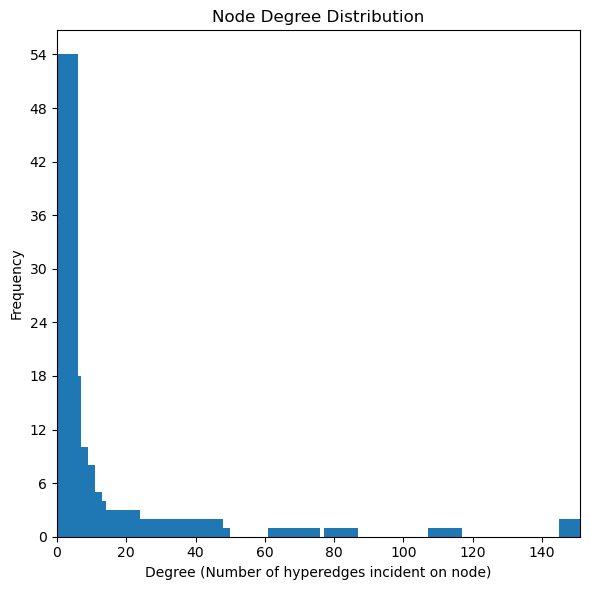

In [24]:
plot_path = 'figures/hg_degree_dist_order_ge1_'+str(details)+'.png'
degree_count_ge1 = plot_degree_distribution(hyperedges_order_ge1, plot_path)

Degree frequencies: [18, 9, 10, 8, 8, 1, 5, 4, 2, 1, 3, 1, 1, 2, 1, 1, 3, 2, 2, 2, 1, 1, 1, 1, 2, 1, 2, 1, 1, 1, 1, 1, 1, 1, 2]


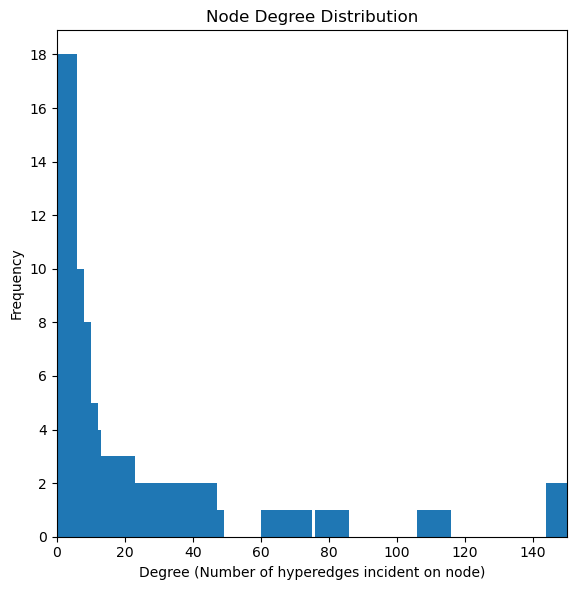

In [25]:
plot_path = 'figures/hg_degree_dist_order_ge2_'+str(details)+'.png'
degree_count_ge2 = plot_degree_distribution(hyperedges_order_ge2, plot_path)

In [26]:
def plot_hyperedge_size_distribution(hyperedges, plot_path):
    hyperedge_size = defaultdict(int)

    for edge in hyperedges:
        hyperedge_size[edge] = len(edge)
    max_edgesize = max(hyperedge_size.values())
    
    # Count the frequency of each hyperedge size
    size_freq = defaultdict(int)
    for size in hyperedge_size.values():
        size_freq[size] += 1

    # Sort the hyperedge sizes and their frequencies
    sorted_sizes = sorted(size_freq.keys())
    sorted_frequencies = [size_freq[size] for size in sorted_sizes]

    # Print the hyperedge size frequencies for verification
    print("Hyperedge size frequencies:", size_freq)

    # Plotting the degree distribution
    plt.figure(figsize=(4, 4))

    # Plot degree distribution as a line plot with bins of length 1
    #plt.plot(sorted_degrees, sorted_frequencies, marker='o', color='blue', linestyle='-', alpha=0.7)
    plt.bar(sorted_sizes, sorted_frequencies, color='tab:blue', width = 0.3)
    plt.title('Hyperedge size distribution')
    plt.xlabel('Size (Number of nodes in a hyperedge)')
    plt.ylabel('Frequency')
    plt.xlim(0, max_edgesize+1)
    
    ax = plt.gca()
    ax.xaxis.set_major_locator(MaxNLocator(integer=True))


    plt.tight_layout()
    plt.savefig(plot_path, dpi = 600)
    plt.show()

Hyperedge size frequencies: defaultdict(<class 'int'>, {1: 156, 2: 394, 3: 232, 4: 32, 5: 1})


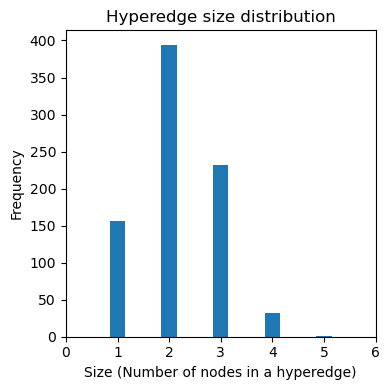

In [27]:
plot_path = 'figures/hg_hyperedge_size_dist_ge1_'+str(details)+'.png'
plot_hyperedge_size_distribution(hyperedges_order_ge1, plot_path)

Hyperedge size frequencies: defaultdict(<class 'int'>, {2: 394, 3: 232, 4: 32, 5: 1})


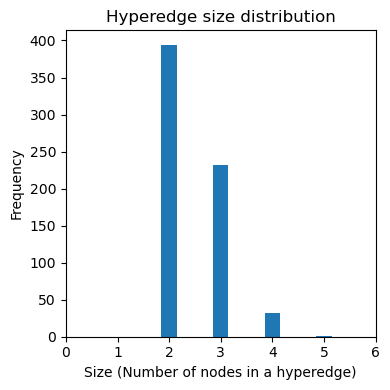

In [28]:
plot_path = 'figures/hg_hyperedge_size_dist_ge2_'+str(details)+'.png'
plot_hyperedge_size_distribution(hyperedges_order_ge2, plot_path)

In [29]:
def plot_heat_map_of_node_degree(degree_count, plot_path):
    degree_grid = np.zeros((20, 20))  # Create a 10x10 grid initialized with zeros

    for (x, y), degree in degree_count.items():
        # Assuming (x, y) are within the range [1, 10]
        if 1 <= x <= 20 and 1 <= y <= 20:
            degree_grid[y-1, x-1] = degree  # Fill in the grid (0-indexed)

    plt.figure(figsize=(8,8))
    sns.heatmap(degree_grid, fmt='.0f', cmap='YlGnBu', cbar=True,
            xticklabels=np.arange(1, 21), yticklabels=np.arange(1, 21))
    plt.title('Node Degree Heatmap', fontsize=16)
    plt.xlabel('X Coordinate', fontsize=12)
    plt.ylabel('Y Coordinate', fontsize=12)
    plt.gca().invert_yaxis()
    plt.tight_layout()
    plt.savefig(plot_path, dpi = 600)
    plt.show()

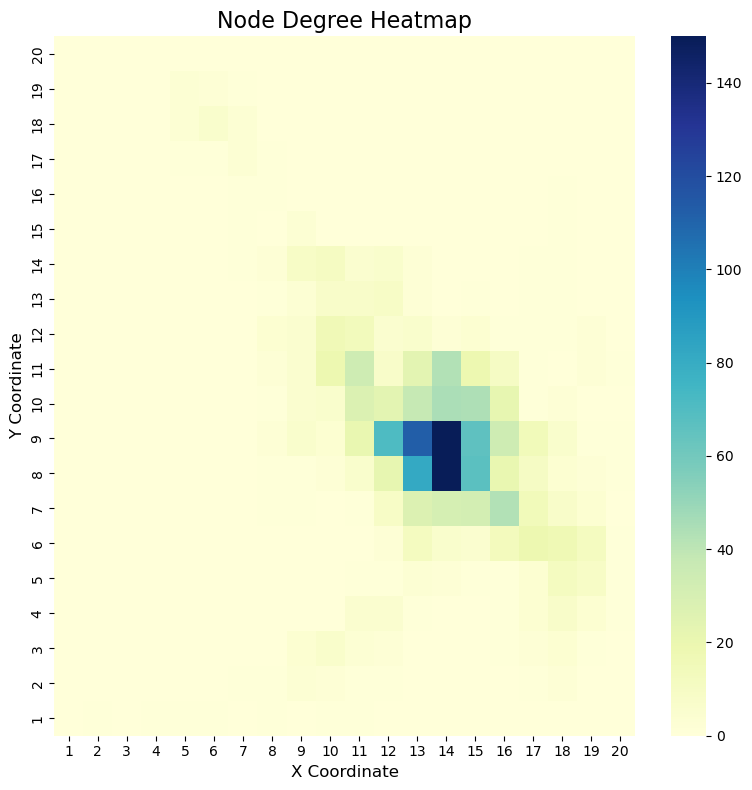

In [30]:
plot_path = 'figures/heat_map_order_ge1_'+str(details)+'.png'
plot_heat_map_of_node_degree(degree_count_ge1, plot_path)

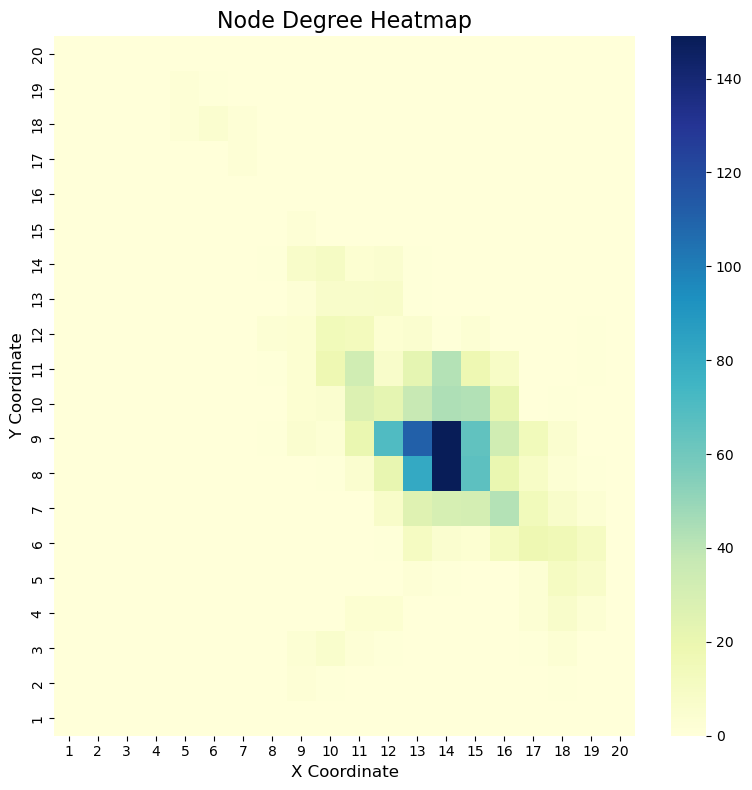

In [31]:
plot_path = 'figures/heat_map_order_ge2_'+str(details)+'.png'
plot_heat_map_of_node_degree(degree_count_ge2, plot_path)

In [32]:
# Create a dictionary mapping (x, y) to node ids
node_id_map = {}

# Initialize node ID counter
node_id = 1

# Loop through each (x, y) coordinate in the grid from (1, 1) to (20, 20)
for x in range(1, 21):  # x goes from 1 to 20
    for y in range(1, 21):  # y goes from 1 to 20
        node_id_map[(x, y)] = node_id
        node_id += 1

# Print the dictionary for verification
print(len(node_id_map))

400


In [33]:
def write_hypergraph_to_edgelist(hypergraph, filename):
    with open(filename, 'w') as f:
        count = 0
        for edge_id, edge in hypergraph.incidence_dict.items():
            edge_nodes = ""
            for i in range(len(edge)):
                edge_nodes += str(node_id_map[edge[i]])+","
            edge_nodes = edge_nodes[:-1]
            # Write edge ID and its corresponding nodes to the file
            f.write(f"{edge_nodes}\n")
            count += 1

In [34]:
write_hypergraph_to_edgelist(H_order_ge1, 'outputs/hypergraph_order_ge1_'+str(details)+'.txt')

In [35]:
write_hypergraph_to_edgelist(H_order_ge2, 'outputs/hypergraph_order_ge2_'+str(details)+'.txt')

In [36]:
write_hypergraph_to_edgelist(H_order_ge3, 'outputs/hypergraph_order_ge3_'+str(details)+'.txt')

In [37]:
write_hypergraph_to_edgelist(H_order_ge4, 'outputs/hypergraph_order_ge4_'+str(details)+'.txt')

In [40]:
def plot_k_uniform_subhypergraph(H, k, plot_path, radius):
    plt.figure(figsize=(6, 6))
    ax = plt.subplot(111)

    # Use node labels directly as (x, y) coordinates
    # Assuming H_order3 nodes are something like (0,0), (5,10), (10,5), etc.
    pos = {node: node for node in H.nodes}  # Node labels are used as positions

    node_labels_kwargs = {
        'fontsize': 10,         # Font size of the node labels
        'color': 'k',        # Color of the node labels
        'verticalalignment': 'top',  # Vertical alignment of the label
        'horizontalalignment': 'left' # Horizontal alignment of the label
    }
    # Draw the hypergraph using the node labels as positions and let edges be drawn normally
    hnx.draw(H, ax=ax, pos=pos, with_edge_labels=False, with_node_labels = True, node_radius=radius,
         node_labels_kwargs=node_labels_kwargs)
    plot_title = str(k)+"-uniform subhypergraph"
    plt.title(plot_title)
    plt.tight_layout()
    plt.savefig(plot_path, dpi = 600)
    plt.show()

In [ ]:
six_uniform_edges = {edge: nodes for edge, nodes in H_order_ge2.incidence_dict.items() if len(nodes) == 6}
H_6_uniform = hnx.Hypergraph(six_uniform_edges)
plot_k_uniform_subhypergraph(H_6_uniform, 6, 'figures/hg_6_uniform_subgraph_'+str(details)+'.png', 0.5)

In [ ]:
five_uniform_edges = {edge: nodes for edge, nodes in H_order_ge2.incidence_dict.items() if len(nodes) == 5}
H_5_uniform = hnx.Hypergraph(five_uniform_edges)
plot_k_uniform_subhypergraph(H_5_uniform, 5, 'figures/hg_5_uniform_subgraph_'+str(details)+'.png', 0.1)

/Users/user/miniconda3/lib/python3.9/site-packages/hypernetx/classes/entityset.py:150: DeprecationWarning: misc_props_col and misc_cell_props_col will be deprecated; all public references to these arguments will be removed in a future release.
  warnings.warn(
/Users/user/miniconda3/lib/python3.9/site-packages/hypernetx/classes/hypergraph.py:563: FutureWarning: This method or function will be deprecated in a future release. Public references to this method or function will be removed from the Hypergraph API in a future release.
  self._nodes = self.E.restrict_to_levels([1])
/Users/user/miniconda3/lib/python3.9/site-packages/hypernetx/classes/entityset.py:618: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  elements = self._dataframe.groupby(col1)[col2].unique().to_dict()
/Users/user/miniconda3/lib/p

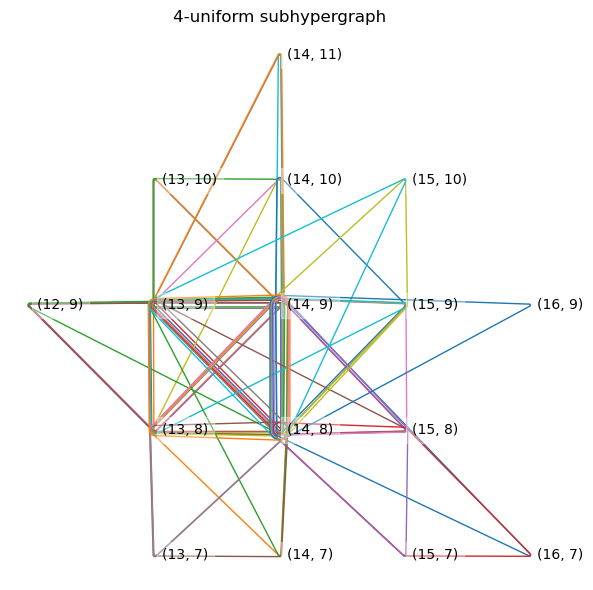

In [41]:
four_uniform_edges = {edge: nodes for edge, nodes in H_order_ge2.incidence_dict.items() if len(nodes) == 4}
H_4_uniform = hnx.Hypergraph(four_uniform_edges)
plot_k_uniform_subhypergraph(H_4_uniform, 4, 'figures/hg_4_uniform_subgraph_'+str(details)+'.png', 0.05)